In [1]:
import os
import sys

import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(".."))

from eda.models import Generation
from eda.parsing import Conversations, Participants

participants = Participants()
conversations = Conversations(participants)

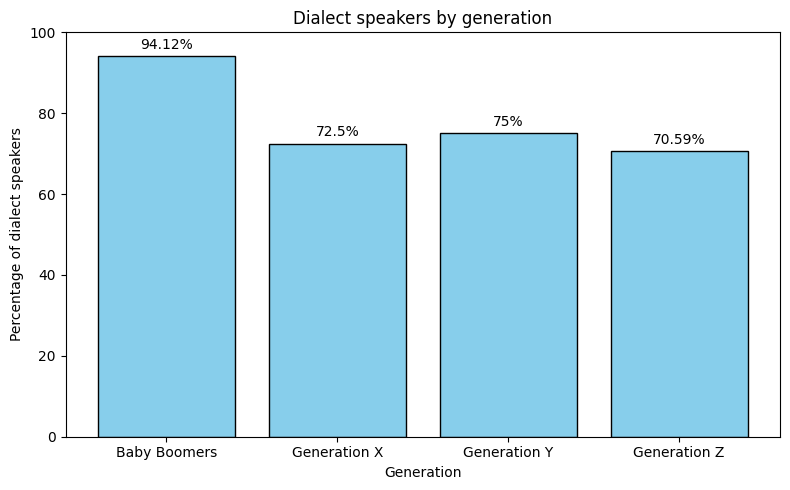

In [ ]:
from eda.models import Participant
from eda.utils import round_precise


def participant_speaks_dialect(participant: Participant) -> bool:
    return bool(conversations.participant_dialect_words(participant))


dialect_counts: dict[Generation, list[int]] = Generation.create_mapping()
for generation in dialect_counts:
    dialect_counts[generation].extend((0, 0))

for participant in participants:
    percentages = dialect_counts[participant.generation]
    percentages[0] += participant_speaks_dialect(participant)
    percentages[1] += 1

generation_names = []
percentages = []
for generation, (speaker_count, participant_count) in dialect_counts.items():
    percentage = round_precise(speaker_count / participant_count * 100, 2)
    generation_names.append(generation.name)
    percentages.append(percentage)

plt.figure(figsize=(8, 5))
plt.bar(generation_names, percentages, color="skyblue", edgecolor="black")
plt.xlabel("Generation")
plt.ylabel("Percentage of dialect speakers")
plt.title("Dialect speakers by generation")
plt.ylim(0, 100)

for i, value in enumerate(percentages):
    plt.text(i, value + 1, f"{value}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()

In [ ]:
conversations.read_all()

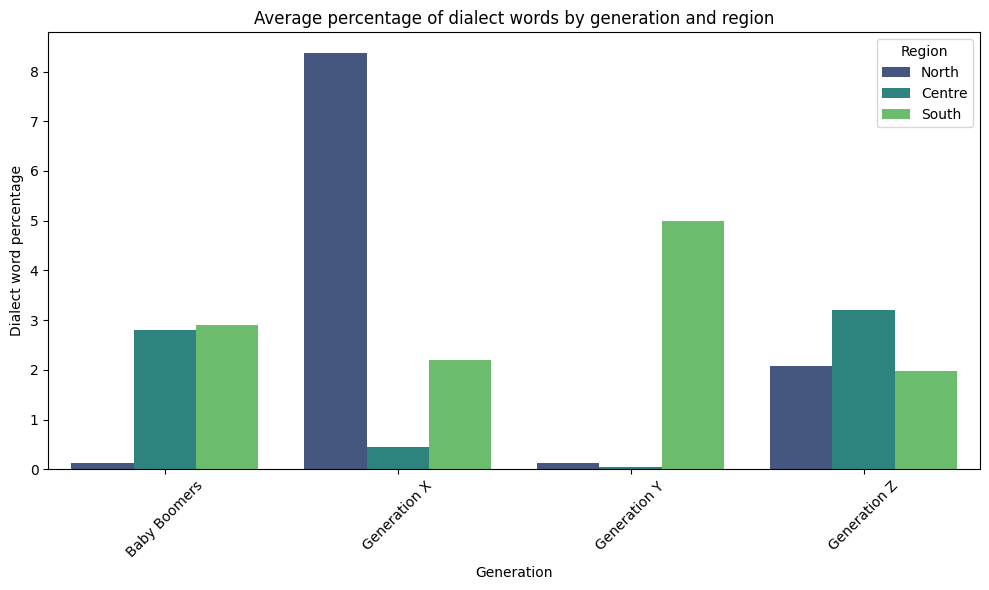

In [ ]:
from collections.abc import Callable, Generator
from functools import cache

import pandas as pd
import seaborn as sns

from eda.language import AttributedWord
from eda.models import MacroRegion, ParticipantLines


def participant_macro_region(participant: Participant) -> MacroRegion:
    conversation = conversations.conversation(participant.conversation_code)
    return conversation.macro_region


def generate_participant_words(lines: ParticipantLines) -> Generator[AttributedWord]:
    for line in lines:
        yield from filter(lambda word: word.is_linguistic, line.normalised_words)

@cache
def participants_dialect_percentages(
    *, rounder: Callable[[int | float, int], int | float] = round_precise
) -> list[int | float]:
    percentages = []

    for participant in participants:
        participant_lines = conversations.participant_lines(participant)
        dialect_words = total_words = 0
        for word in generate_participant_words(participant_lines):
            dialect_words += word.is_dialect(strict=False)
            total_words += 1

        percentange_of_dialect_words = rounder(dialect_words / total_words * 100, 2)
        percentages.append(percentange_of_dialect_words)

    return percentages


percentages = participants_dialect_percentages()
generations = [participant.generation.name for participant in participants]
macro_regions = [
    participant_macro_region(participant).name.capitalize()
    for participant in participants
]

df = pd.DataFrame({
    "dialect_percentage": percentages,
    "generation": generations,
    "region": macro_regions,
})

grouped = (
    df.groupby(["generation", "region"], observed=True)
    .agg(
        dialect_percentage=("dialect_percentage", "mean"),
        n_speakers=("dialect_percentage", "count"),
    )
    .reset_index()
)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=grouped,
    x="generation",
    y="dialect_percentage",
    hue="region",
    hue_order=["North", "Centre", "South"],
    palette="viridis",
)

plt.title("Average percentage of dialect words by generation and region")
plt.ylabel("Dialect word percentage")
plt.xlabel("Generation")
plt.legend(title="Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

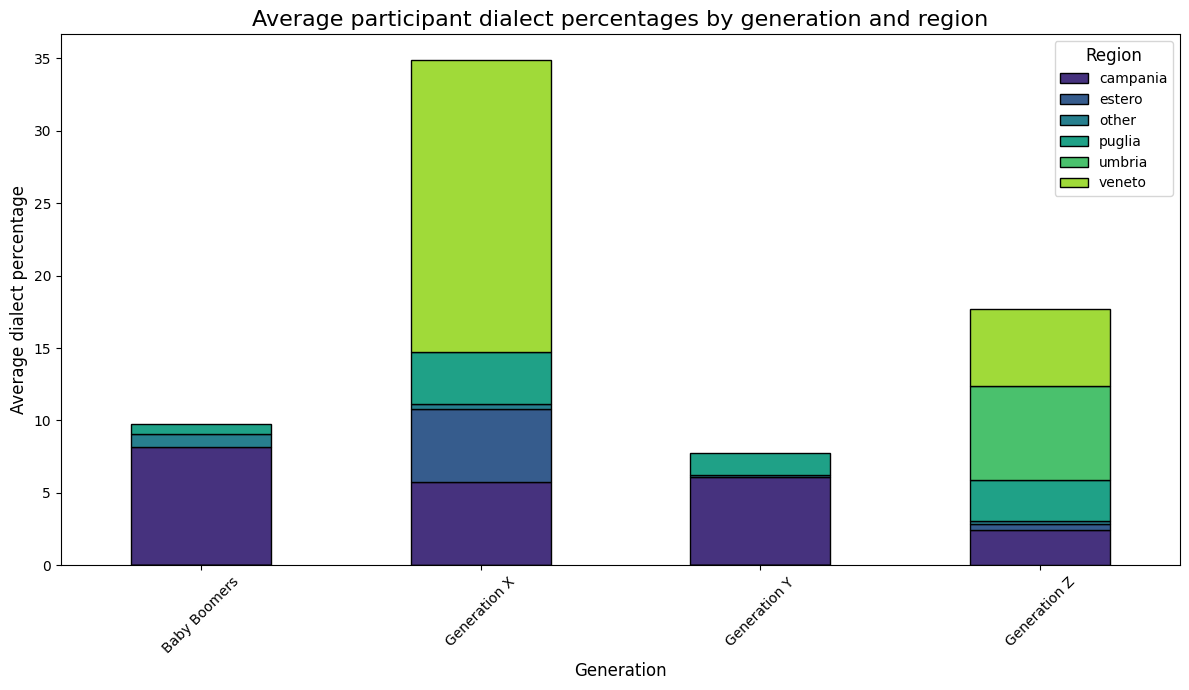

In [ ]:
from collections import defaultdict

data = []
region_percentages = defaultdict(float)

dialect_percentages = iter(participants_dialect_percentages())
for participant in participants:
    region = participant.geographic_origin
    percentage = next(dialect_percentages)
    participant_data = {
        "generation": participant.generation.name,
        "dialect_percentage": percentage,
        "region": region
    }
    region_percentages[region] += percentage
    data.append(participant_data)

top_n = 5
top_regions = frozenset(region for region, _ in sorted(region_percentages.items(), key=lambda pair: pair[1], reverse=True)[:top_n])

for participant_data in data:
    region = participant_data["region"]
    if region not in top_regions:
        participant_data["region"] = "other"

region_df = pd.DataFrame(data)
region_df = region_df.groupby(["generation", "region"])["dialect_percentage"].mean().unstack()
region_df = region_df.sort_values(by="generation")

plt.figure(figsize=(12, 7))

colors = sns.color_palette("viridis", n_colors=len(region_df.columns))

region_df.plot(
    kind="bar",
    stacked=True,
    color=colors,
    ax=plt.gca(),
    edgecolor="black"
)

plt.title(f"Average participant dialect percentages by generation and region (top {top_n})", fontsize=16)
plt.ylabel("Average dialect percentage", fontsize=12)
plt.xlabel("Generation", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Region", fontsize=10, title_fontsize=12, loc="upper right")
plt.tight_layout()
plt.show()


In [ ]:
import asyncio
import json
from collections import defaultdict
from typing import Optional

from eda.llm import MessageFactory, ModelResponseGenerator
from eda.models import Conversation
from eda.utils import FOLDER_DIR, PROMPTS_PATH, round_precise


def read_conversation_text(conversation: Conversation) -> str:
    builder = []
    for line in conversation:
        builder.append(line.normalised_text)
    return ' '.join(builder)

sparql_data_path = FOLDER_DIR / "data" / "sparql_data.json"
with sparql_data_path.open() as fp:
    sparql_data = json.load(fp)

lod_themes: frozenset[str] = frozenset(map(str.title, sparql_data["conversation_types"]))
prompt_text = PROMPTS_PATH.joinpath("themes_prompt.txt").read_text()
prompt = prompt_text.replace("{themes}", ', '.join(lod_themes))

conversations.read_all()

def try_parse_response(content: str) -> Optional[list[str]]:
    try:
        data = json.loads(content)
    except json.JSONDecodeError:
        return None
    
    if (applicable_themes := data.get("applicable_themes")) is None:
        return None
    
    if not applicable_themes or not isinstance(applicable_themes, list):
        return None
    
    applicable_themes = list(map(str.title, applicable_themes))
    if any(theme not in lod_themes for theme in applicable_themes):
        return None
    
    return applicable_themes

async def generate_conversation_themes(*, prompt: str) -> dict[str, set[str]]:
    themes_by_conversation = defaultdict(set)

    data = []
    n_responses_awaiting = 0
    part_size = 500
    for conversation in conversations:
        text = read_conversation_text(conversation)
        for i in range(0, len(text), part_size):
            part = text[i:i + part_size]
            data.append((conversation, part))
            n_responses_awaiting += 1

    print("Read conversation texts")
    n_responses = 0
    factory = MessageFactory(prompt)

    async with asyncio.TaskGroup() as task_group:
        response_generator = ModelResponseGenerator(task_group)
        task_group.create_task(response_generator.run())

        for conversation, content in data:
            await response_generator.enqueue(
                factory.create_message(content, code=conversation.code)
            )

        while n_responses < n_responses_awaiting:
            if (response := await response_generator.poll_response()) is None:
                await response_generator.wait()
                continue

            if (applicable_themes := try_parse_response(response.content)) is None:
                print("Cannot parse:", response.content)
                await response_generator.enqueue(response)
                await response_generator.wait()
                continue

            print("Received", applicable_themes, "for", response.metadata["code"])
            print(f"{n_responses}/{n_responses_awaiting} ({round_precise(n_responses / n_responses_awaiting * 100, 2)}%)")

            n_responses += 1
            themes_by_conversation[response.metadata["code"]] |= set(applicable_themes)

        await response_generator.enqueue(None)
    return themes_by_conversation

print("LOD themes: ", lod_themes)
themes_by_conversation = await generate_conversation_themes(prompt=prompt)

print("Results: ")
for conversation_code, themes in themes_by_conversation.items():
    print(conversation_code, "contains the themes", ', '.join(themes))

Only include conversations where all participants are from the same generation, and treat separate permutations of generations as separate data.

This is an error in the way the data is collected but has the upside of the results (likely) being more accurate.

There would be mistakes in filtering out specific topics from multigenerational conversations, as one speaker might have a tendency to bring up a certain topic if they are from a generation due to their experiences.

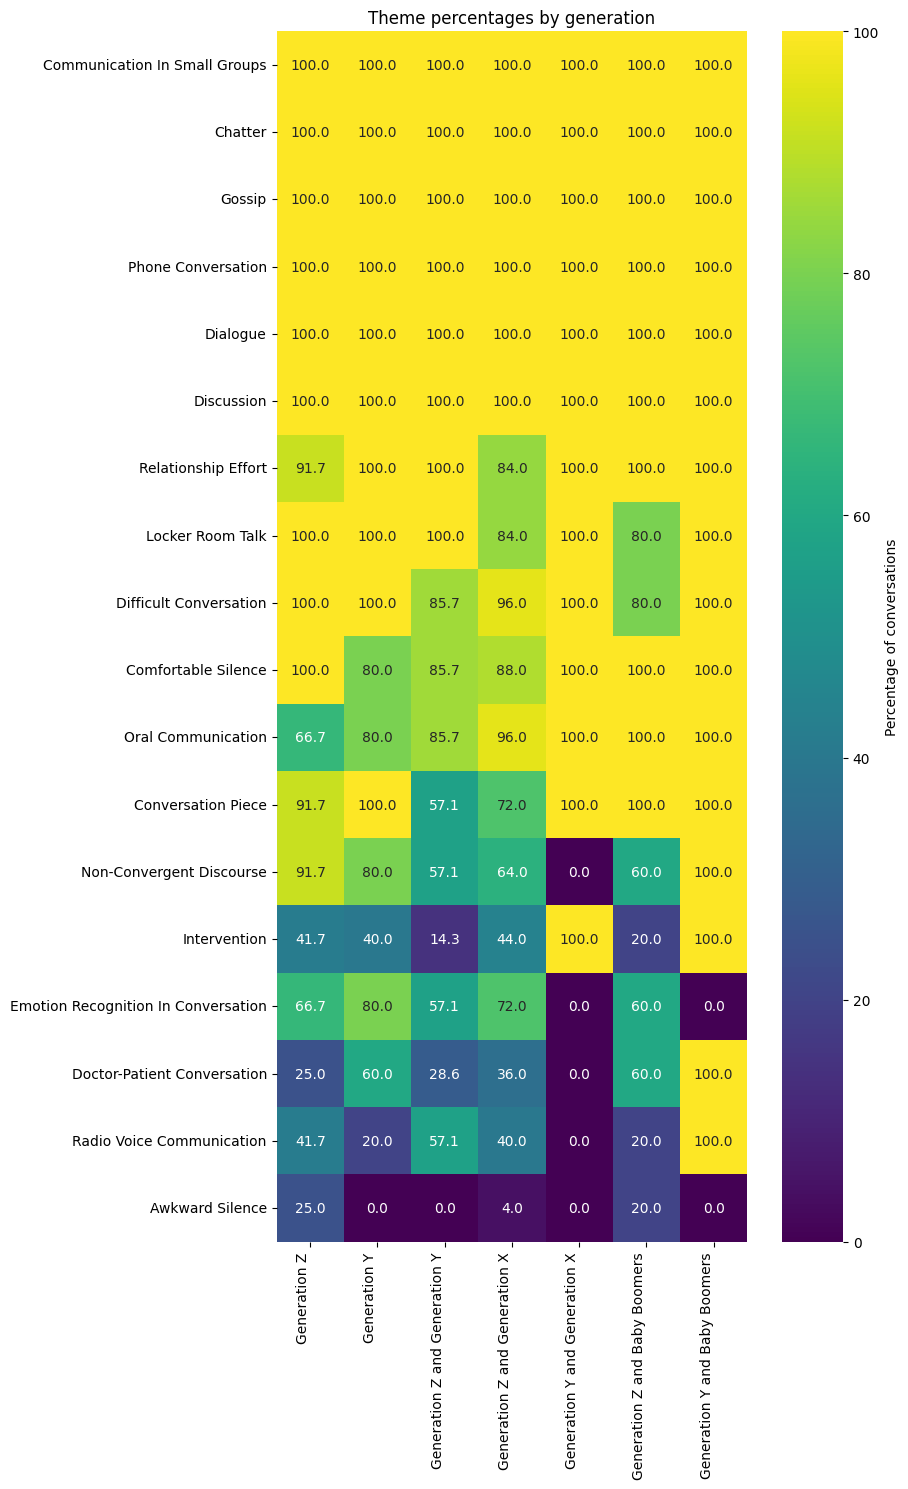

In [104]:
import json
import operator
from collections import Counter
from collections.abc import Iterable
from typing import Any, cast

import pandas as pd
import seaborn as sns

from eda.utils import round_precise

ML_THEMES_BY_CODE = json.loads(
    FOLDER_DIR.joinpath("data").joinpath("ml_gen_themes_by_code.json").read_text()
)

totals = defaultdict(int)
generation_themes = defaultdict(Counter)

def andjoin(it: Iterable[Any], sep: str = ", ") -> str:
    *elements, last = it
    if not elements:
        return str(last)
    return f"{sep.join(map(str, elements))} and {last}"

Generation._include_range_in_str = False

for code, themes in ML_THEMES_BY_CODE.items():
    conversation = conversations.conversation(code)
    generations = list(map(operator.attrgetter("generation"), conversation.participants))
    generation = generations[0]
    if len(set(generations)) == 3:
        continue

    if all(generation == other_generation for other_generation in generations):
        generation_id = (generation, pd.NA, pd.NA, pd.NA)
        generation_themes[generation_id] += Counter(themes)
        totals[generation_id] += 1
    else:
        generations_id = sorted(frozenset(generations))
        for _ in range(4 - len(generations_id)):
            generations_id.append(pd.NA)
        generations_id = tuple(generations_id)

        generation_themes[generations_id] += Counter(themes)
        totals[generations_id] += 1

for name, total in totals.items():
    generation_themes[name] = { # type: ignore
        key: round_precise(value / total * 100, 2)
        for key, value in generation_themes[name].items()
    }

def sorter(key: tuple[Generation, ...]) -> tuple[int, ...]:
    values = [0] * 4
    for generation in key:
        if generation == Generation.BOOMERS:
            values[0] += 1
        elif generation == Generation.X:
            values[1] += 1
        elif generation == Generation.Y:
            values[2] += 1
        elif generation == Generation.Z:
            values[3] += 1
    return tuple(values)

df = pd.DataFrame(generation_themes).T.fillna(0)
df = df[df.sum().sort_values(ascending=False).index]

sorted_index = sorted(df.index, key=sorter)
df = df.reindex(sorted_index)
df.index = cast(Any, [
    andjoin(tuple(val for val in index if isinstance(val, Generation))) 
    for index in df.index.values
])
df = df.T

plt.figure(figsize=(9, 15))
sns.heatmap(
    df, 
    square=True,
    annot=True, 
    fmt=".1f",
    cmap="viridis", 
    cbar_kws={"label": "Percentage of conversations"}
)

plt.title("Theme percentages by generation")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()